In [1]:
#pip install -e git+https://github.com/FrederikFertin/PyEPO.git@development#egg=pyepo

In [1]:
import gurobipy as gp
from gurobipy import GRB
import numpy as np
import pyepo
from pyepo.model.grb import optGrbModel
import torch
from torch import nn
from torch.utils.data import DataLoader
from gurobipy import Model, GRB, quicksum

import pandas as pd

import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline

#from sklearn_extra.cluster import KMedoids
import copy

device = torch.device('cuda' if torch.has_cuda else 'cpu')

Auto-Sklearn cannot be imported.


In [25]:
# load data
red = (0.77, 0, 0.05) # (196, 0, 13)
blue = (0.12, 0.24, 1) # (31, 61, 255)
# green = (0.31, 1, 0.34) # (79, 255, 87)
green = (0.122, 00.816, 0.51) # (31, 208, 130)
navyblue = (0, 0, 0.4) # (0, 0, 102)
black = (0, 0, 0)
white = (1, 1, 1)
cgreen = (0.57254902, 0.7254902 , 0.51372549) # (146, 185, 131)
cblue = (0.70196078, 0.83137255, 1) # (179, 212, 255)

top_domain = 53.32 # 90% quantile



def import_data(negative_prices=False):
    # import data and set constants
    all_data = pd.read_csv("2020_data.csv")
    prices_UP = np.maximum(all_data["UP"].to_numpy(),0)
    prices_DW = np.maximum(all_data["DW"].to_numpy(),0)
    prices_F = np.maximum(all_data["forward_RE"].to_numpy(),0)
    prices_forecast = np.maximum(all_data["forward_FC"].to_numpy(), 0)

    nominal_wind = 10
    features = all_data.loc[:, ["Offshore DK2", "Offshore DK1", "Onshore DK2", "Onshore DK1", "production_FC"]]
    features["forward"] = prices_F
    features_red = all_data.loc[:, ["production_FC"]]
    features_red["forward"] = prices_F
    realized = all_data.loc[:, "production_RE"].to_numpy()
    realized *= nominal_wind

    price_H = 35.2
    penalty = np.quantile(prices_UP, 0.95) # 95% quantile of deficit_settle price over all 2 years
    # penalty = 2 * price_H
    # penalty = np.max(prices_B) # Something HIGHER is needed apparently

    return (
        prices_UP,
        prices_DW,
        prices_F,
        prices_forecast,
        features,
        features_red,
        realized,
        price_H,
        penalty
    )

In [26]:
# c = [lambda_H, lambda_F, -lambda_UP, lambda_DW, -penalty]

In [4]:
import os
# get current directory
path = os.getcwd()
import os.path

def getParent(path, levels = 1):
    common = path
 
    # Using for loop for getting
    # starting point required for
    # os.path.relpath()
    for i in range(levels + 1):
 
        # Starting point
        common = os.path.dirname(common)
 
    # Parent directory upto specified
    # level
    return os.path.relpath(path, common)


In [27]:
#Import data
(prices_UP,prices_DW,prices_F,prices_forecast,features,features_red,realized,price_H,penalty) = import_data()

# Change forward prices to forecast prices in features
features["forward"] = prices_forecast

periods = list(range(0, len(prices_F) )) # Total time considered 2020-2021
n_periods = 24 # Number of periods in a day
n_days = 50 # Number of days in training set and test set
n_hours = n_days * n_periods
num_feat = n_periods*6 # size of feature
num_feat_rf = 2 # size of feature
num_item = 120 # number of predictions (Forward bid and Hydrogen)

lambda_H_list = [price_H for i in range(n_periods)]
penalty_list = [-penalty for i in range(n_periods)]

def flatten_extend(matrix):
     flat_list = []
     for row in matrix:
         flat_list.extend(row)
     return flat_list

In [28]:
# 
c_train = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], penalty_list]) for d in range(int(n_hours/n_periods))])
c_test = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], penalty_list]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])
wind_train = np.asarray([flatten_extend([realized[d:d+n_periods]]) for d in range(int(n_hours/n_periods))])
wind_test = np.asarray([flatten_extend([realized[d:d+n_periods]]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])
x_train = np.asarray([flatten_extend(features.values[d:d+n_periods]) for d in range(int(n_hours/n_periods))])
x_test = np.asarray([flatten_extend(features.values[d:d+n_periods]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])

# Standardize x_train and x_test
x_train = (x_train - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)
x_test = (x_test - np.mean(x_train, axis=0)) / np.std(x_train, axis=0)

# As matrix:
#c_train = np.asarray([np.transpose([lambda_H_list, prices_F[d: d+n_periods], prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], penalty_list]) for d in range(int(n_hours/n_periods))])
#c_test = np.asarray([np.transpose([lambda_H_list, prices_F[d: d+n_periods], prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], penalty_list]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])
#c_train = np.asarray([[lambda_H_list, prices_F[d: d+n_periods], prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], penalty_list] for d in range(int(n_hours/n_periods))])
#c_test = np.asarray([[lambda_H_list, prices_F[d: d+n_periods], prices_UP[d: d+n_periods], prices_DW[d: d+n_periods], penalty_list] for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])

In [7]:

# optimization model
class myModel(optGrbModel):
    def __init__(self, realized, *args, **kwargs):        
        #Fixed parameters
        self.max_elec = 10
        self.max_wind = 10
        self.nominal_wind = 10
        self.min_production = 50
        self.periods = np.arange(len(realized))
        self.E_real = realized
        super().__init__()

    def _getModel(self):

        initial_plan = Model("Gurobi.Optimizer")

        # Definition of variables
        x = initial_plan.addMVar((5,len(self.periods)), name="x")
        """
        hydrogen_plan = initial_plan.addVars(self.periods, name="p_H", lb=0)
        forward_bid = initial_plan.addVars(self.periods, name="p_F")
        p_UP = initial_plan.addVars(self.periods, name="p_UP", lb=0)
        p_DW = initial_plan.addVars(self.periods, name="p_DW", lb=0)
        p_slack = initial_plan.addVars(self.periods, name="p_slack", lb=0)
        """

        # Objective: Maximize profit
        initial_plan.modelSense = GRB.MAXIMIZE
        #initial_plan.setObjective(
        #    quicksum(
        #        lambda_F[t] * p_F[t] +
        #        lambda_H * hydrogen[t] +
        #        lambda_DW[t] * E_DW[t] -
        #        lambda_UP[t] * E_UP[t]
        #        for t in periods
        #    ), GRB.MAXIMIZE
        #)

        # Constraints
        # Max capacity
        for t in self.periods:
            """
            initial_plan.addConstr(forward_bid[t] <= self.max_wind, name=f"wind_capacity_up_{t}")
            initial_plan.addConstr(forward_bid[t] >= -self.max_elec, name=f"wind_capacity_dw_{t}")
            initial_plan.addConstr(hydrogen_plan[t] <= self.max_elec, name=f"elec_capacity_{t}")
            initial_plan.addConstr(self.E_real[t] - hydrogen_plan[t] - forward_bid[t] == p_UP[t] - p_DW[t], name=f"balancing_{t}")
            initial_plan.addConstr(hydrogen_plan[t] + self.min_production/len(self.periods) - p_slack[t] <= 0, name=f"slack_{t}")
            """
            initial_plan.addConstr(x[1,t] <= self.max_wind, name=f"wind_capacity_up_{t}")
            initial_plan.addConstr(x[1,t] >= -self.max_elec, name=f"wind_capacity_dw_{t}")
            initial_plan.addConstr(x[0,t] <= self.max_elec, name=f"elec_capacity_{t}")
            initial_plan.addConstr(x[0,t] >= 0, name=f"elec_capacity_lb_{t}")
            initial_plan.addConstr(x[2,t] >= 0, name=f"up_regulation_lb_{t}")
            initial_plan.addConstr(x[2,t] <= 2*self.max_wind, name=f"up_regulation_lb_{t}")
            initial_plan.addConstr(x[3,t] >= 0, name=f"dw_regulation_lb_{t}")
            initial_plan.addConstr(x[3,t] <= 2*self.max_wind, name=f"dw_regulation_lb_{t}")
            initial_plan.addConstr(x[4,t] >= 0, name=f"slack_regulation_lb_{t}")
            initial_plan.addConstr(x[4,t] <= self.min_production/len(self.periods), name=f"slack_regulation_ub_{t}")
            initial_plan.addConstr(self.E_real[t] - x[0,t] - x[1,t] == -x[2,t] + x[3,t], name=f"balacing_{t}")
            initial_plan.addConstr(-x[0,t] + self.min_production/len(self.periods) - x[4,t] <= 0, name=f"slack_{t}")

        # Finalizing model setup
        #initial_plan.update()
        #print(type(hydrogen_plan))
        #x = dict(hydrogen_plan).update(dict(forward_bid)).update(dict(p_UP)).update(dict(p_DW)).update(dict(p_slack))
        #print(hydrogen_plan, forward_bid, p_UP, p_DW, p_slack)
        #x = initial_plan.getVars()
        #x = dict(zip([v.varName for v in x], x))
        
        return initial_plan, x

In [29]:
# get optDataset
from pyepo.data.datasetParams import optDatasetParams

#dataset_train = pyepo.data.dataset.optDataset(myModel(wind_train[0]), x_train, c_train)
#dataset_test = pyepo.data.dataset.optDataset(myModel(wind_train[0]), x_test, c_test)

dataset_train = optDatasetParams(myModel, x_train, c_train, wind_train)
dataset_test = optDatasetParams(myModel, x_test, c_test, wind_test)

batch_size = 1
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: For optModel, the method 'solve' should return solution vector and objective value.

# Training with fixed regression outputs for hydrogen and penalty costs.

In [ ]:
# prediction model
from torch import nn
class LinearRegressionCostVector(nn.Module):

    def __init__(self, input_size, output_size, constant_indices, constant_values, mask):
        super(LinearRegressionCostVector, self).__init__()
        self.linear = nn.Linear(input_size, output_size)
        self.constant_indices = constant_indices
        self.constant_values = constant_values
        self.mask = mask

    def forward(self, x):
        out = self.linear(x)
        for i in range(len(self.constant_indices)):
            if self.constant_indices[i] == 1:
                if i < 24:
                    out[:,i] = self.constant_values[0]
                else:
                    out[:,i] = self.constant_values[1]
        return out

# Initialize the model
constant_indices = np.zeros(num_item)
constant_indices[0:24] = 1
constant_indices[num_item-24:num_item] = 1
grad_mask = (constant_indices == 0).astype(int)

reg = LinearRegressionCostVector(num_feat, num_item, constant_indices=constant_indices, constant_values=[price_H, -penalty], mask=grad_mask)

In [24]:
from pyepo.metric.regretParams import regretParams
#regret = regretParams(reg, myModel, loader_test, wind_test)

def custom_backward(loss, model):
    loss.backward()
    for param in model.parameters():
        if param.grad is not None:
            param.grad = (param.grad.T * model.mask).T.type(torch.FloatTensor)

In [ ]:
import time
from tqdm import tqdm

# train model
def trainModel(reg, loss_function, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [regretParams(reg, myModel, loader_test, wind_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(tqdm(loader_train)):
            wind = wind_train[i]
            opt_model = myModel(wind)
            loss_func = loss_function(opt_model, processes=1)
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            custom_backward(loss, reg)
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        regret = regretParams(reg, myModel, loader_test, wind_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [23]:
from matplotlib import pyplot as plt

def visLearningCurve(loss_log, loss_log_regret):
    # create figure and subplots
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,4))

    # draw plot for training loss
    ax1.plot(loss_log, color="c", lw=1)
    ax1.tick_params(axis="both", which="major", labelsize=12)
    ax1.set_xlabel("Iters", fontsize=16)
    ax1.set_ylabel("Loss", fontsize=16)
    ax1.set_title("Learning Curve on Training Set", fontsize=16)

    # draw plot for regret on test
    ax2.plot(loss_log_regret, color="royalblue", ls="--", alpha=0.7, lw=1)
    ax2.set_xticks(range(0, len(loss_log_regret), 2))
    ax2.tick_params(axis="both", which="major", labelsize=12)
    ax2.set_ylim(0, 1)
    ax2.set_xlabel("Epochs", fontsize=16)
    ax2.set_ylabel("Regret", fontsize=16)
    ax2.set_title("Learning Curve on Test Set", fontsize=16)

    plt.show()

In [ ]:
import torch
# init model
#reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()
# init SPO+ loss
spop = pyepo.func.SPOPlus
# spop = pyepo.func.SPOPlus(optmodel, processes=2)

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_function=spop, method_name="spo+")

  0%|          | 0/50 [00:00<?, ?it/s]C:\Users\Frede\AppData\Local\Temp\ipykernel_8500\3410439245.py:8: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ..\aten\src\ATen\native\TensorShape.cpp:3679.)
  param.grad = (param.grad.T * model.mask).T.type(torch.FloatTensor)
100%|██████████| 50/50 [00:08<00:00,  5.81it/s]


Epoch  1,  Loss: 21962.5820,  Regret: 18.6432%


100%|██████████| 50/50 [00:08<00:00,  5.79it/s]


Epoch  2,  Loss: 20858.7910,  Regret: 20.7233%


100%|██████████| 50/50 [00:08<00:00,  5.89it/s]


Epoch  3,  Loss: 18408.9102,  Regret: 43.3761%


100%|██████████| 50/50 [00:09<00:00,  5.32it/s]


Epoch  4,  Loss: 13436.7090,  Regret: 47.3286%


100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch  5,  Loss: 11923.6973,  Regret: 64.9291%


100%|██████████| 50/50 [00:09<00:00,  5.21it/s]


Epoch  6,  Loss: 8301.2471,  Regret: 66.9053%


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch  7,  Loss: 6878.0557,  Regret: 65.2661%


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


Epoch  8,  Loss: 4717.0073,  Regret: 68.1235%


100%|██████████| 50/50 [00:09<00:00,  5.53it/s]


Epoch  9,  Loss: 4089.5913,  Regret: 67.7689%


100%|██████████| 50/50 [00:08<00:00,  5.61it/s]


Epoch 10,  Loss: 3012.8916,  Regret: 67.2469%


100%|██████████| 50/50 [00:08<00:00,  6.00it/s]


Epoch 11,  Loss: 2225.3982,  Regret: 67.0751%


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


Epoch 12,  Loss: 2038.2482,  Regret: 66.2378%


100%|██████████| 50/50 [00:08<00:00,  5.74it/s]


Epoch 13,  Loss: 1150.3965,  Regret: 68.9976%


100%|██████████| 50/50 [00:08<00:00,  5.85it/s]


Epoch 14,  Loss:  957.5940,  Regret: 66.2068%


100%|██████████| 50/50 [00:09<00:00,  5.17it/s]


Epoch 15,  Loss:  920.8848,  Regret: 66.1215%


100%|██████████| 50/50 [00:10<00:00,  4.91it/s]


Epoch 16,  Loss:  763.4749,  Regret: 66.9851%


100%|██████████| 50/50 [00:09<00:00,  5.39it/s]


Epoch 17,  Loss: 1027.3145,  Regret: 65.6149%


100%|██████████| 50/50 [00:08<00:00,  5.98it/s]


Epoch 18,  Loss: 1438.0355,  Regret: 66.1509%


100%|██████████| 50/50 [00:08<00:00,  5.99it/s]


Epoch 19,  Loss: 1077.3135,  Regret: 65.6259%


100%|██████████| 50/50 [00:08<00:00,  5.86it/s]

Epoch 20,  Loss:  725.3096,  Regret: 65.7945%
Total Elapsed Time: 5227.61 Sec.


In [ ]:
loss_log_regret

[0.431160161814534,
 0.3357062588386604,
 0.43746250333649733,
 0.4827612970862749,
 0.49337293811682836,
 0.5102678374796383,
 0.5208611726278124,
 0.5237478721281125,
 0.5306082157524696,
 0.5181097178151353,
 0.5264264219434299,
 0.5236979828756377,
 0.511140181392179,
 0.5173635042441425,
 0.5127959052404437,
 0.5128035989331803,
 0.5145383012145396,
 0.5135478769698005,
 0.5087120412045422,
 0.5144781035719611,
 0.5081257758977854]

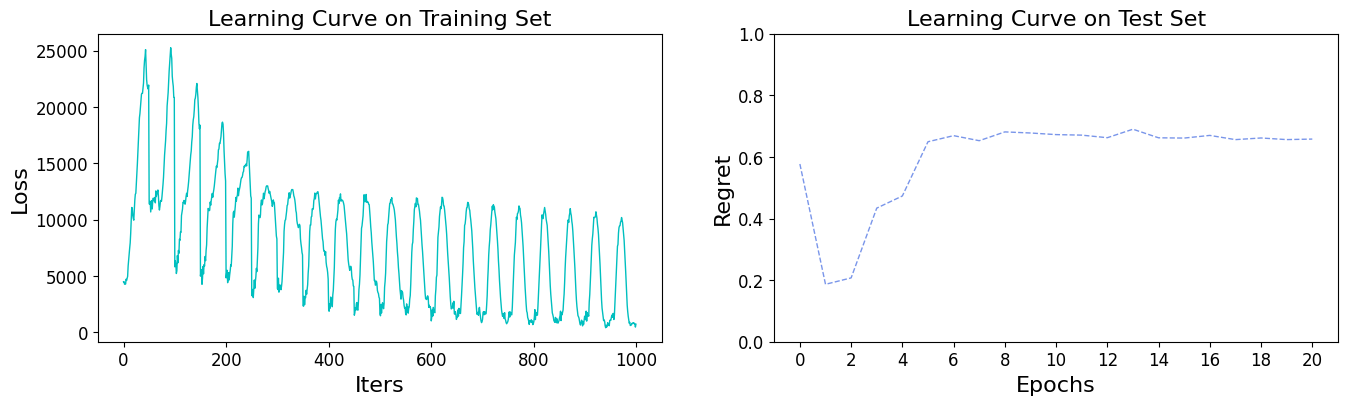

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

# Training without fixing regression model output for hydrogen and penalty


In [ ]:
# prediction model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        #self.linear = nn.Linear(num_feat, num_item)
        self.linear = nn.Sequential( 
            nn.Linear(input_size, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        out = self.linear(x)
        return out

reg = LinearRegression(num_feat, num_item)

In [ ]:
from pyepo.metric.regretParams import regretParams
#regret = regretParams(reg, myModel, loader_test, wind_test)

In [ ]:
import time
from tqdm import tqdm

# train model
def trainModel(reg, loss_function, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [regretParams(reg, myModel, loader_test, wind_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(tqdm(loader_train)):
            wind = wind_train[i]
            opt_model = myModel(wind)
            loss_func = loss_function(opt_model, processes=1)
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        lr_scheduler.step()
        regret = regretParams(reg, myModel, loader_test, wind_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [ ]:
import torch
# init model
reg = LinearRegression()
# cuda
if torch.cuda.is_available():
    reg = reg.cuda()
# init SPO+ loss
spop = pyepo.func.SPOPlus
# spop = pyepo.func.SPOPlus(optmodel, processes=2)

In [ ]:
loss_log, loss_log_regret = trainModel(reg, loss_function=spop, method_name="spo+")

100%|██████████| 50/50 [00:10<00:00,  4.72it/s]


Epoch  1,  Loss: 5527.8027,  Regret:  5.8345%


100%|██████████| 50/50 [00:15<00:00,  3.19it/s]


Epoch  2,  Loss: 5935.5898,  Regret:  8.2725%


100%|██████████| 50/50 [00:09<00:00,  5.06it/s]


Epoch  3,  Loss: 3289.2344,  Regret:  5.8869%


100%|██████████| 50/50 [00:09<00:00,  5.52it/s]


Epoch  4,  Loss: 3475.5535,  Regret:  6.2483%


100%|██████████| 50/50 [00:12<00:00,  3.92it/s]


Epoch  5,  Loss: 2333.8855,  Regret:  9.1146%


100%|██████████| 50/50 [00:12<00:00,  4.02it/s]


Epoch  6,  Loss: 5472.0020,  Regret:  5.5254%


100%|██████████| 50/50 [00:12<00:00,  3.90it/s]


Epoch  7,  Loss: 3340.9192,  Regret:  7.5809%


100%|██████████| 50/50 [00:09<00:00,  5.55it/s]


Epoch  8,  Loss: 2723.5771,  Regret:  7.0122%


100%|██████████| 50/50 [00:09<00:00,  5.48it/s]


Epoch  9,  Loss: 2540.3765,  Regret:  8.1016%


100%|██████████| 50/50 [00:09<00:00,  5.44it/s]


Epoch 10,  Loss: 2941.0417,  Regret:  8.7097%


100%|██████████| 50/50 [00:09<00:00,  5.29it/s]


Epoch 11,  Loss: 2673.4783,  Regret: 11.5251%


100%|██████████| 50/50 [00:11<00:00,  4.28it/s]


Epoch 12,  Loss: 1908.4738,  Regret:  6.4483%


100%|██████████| 50/50 [00:09<00:00,  5.07it/s]


Epoch 13,  Loss: 2280.7246,  Regret:  5.8282%


100%|██████████| 50/50 [00:11<00:00,  4.25it/s]


Epoch 14,  Loss: 2909.9565,  Regret:  5.5211%


100%|██████████| 50/50 [00:15<00:00,  3.21it/s]


Epoch 15,  Loss: 3192.3013,  Regret:  6.2752%


100%|██████████| 50/50 [00:11<00:00,  4.50it/s]


Epoch 16,  Loss: 2990.0073,  Regret:  6.1019%


100%|██████████| 50/50 [00:09<00:00,  5.09it/s]


Epoch 17,  Loss: 1706.5533,  Regret:  7.6812%


100%|██████████| 50/50 [00:09<00:00,  5.40it/s]


Epoch 18,  Loss: 3481.8940,  Regret:  5.5254%


100%|██████████| 50/50 [00:09<00:00,  5.42it/s]


Epoch 19,  Loss: 2033.1821,  Regret:  5.6383%


100%|██████████| 50/50 [00:11<00:00,  4.33it/s]

Epoch 20,  Loss: 2203.3367,  Regret:  5.9590%
Total Elapsed Time: 6539.34 Sec.


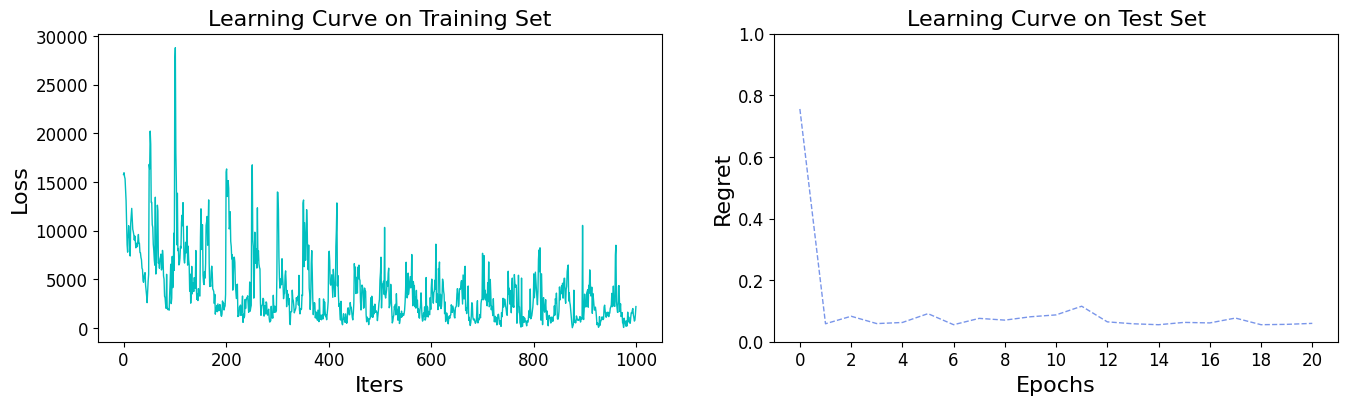

In [ ]:
visLearningCurve(loss_log, loss_log_regret) # 50% dropout rate - gamma = 0.98

In [9]:
#visLearningCurve(loss_log, loss_log_regret) # 20% dropout rate - gamma = 0.98

In [10]:
#visLearningCurve(loss_log, loss_log_regret) # No dropout rate - no exponential learning rate

# Real intertemporal model

In [22]:
num_feat = n_periods*6 # size of feature
num_item = 4*24 # number of predictions (Forward bid and Hydrogen)
c_train = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods]]) for d in range(int(n_hours/n_periods))])
c_test = np.asarray([flatten_extend([lambda_H_list, prices_F[d: d+n_periods], -prices_UP[d: d+n_periods], prices_DW[d: d+n_periods]]) for d in range(int(n_hours/n_periods), int(2*n_hours/n_periods))])


In [12]:

# optimization model
class hydrogenPlanning(optGrbModel):
    def __init__(self, realized, *args, **kwargs):        
        #Fixed parameters
        self.max_elec = 10
        self.max_wind = 10
        self.nominal_wind = 10
        self.min_production = 50
        self.periods = np.arange(len(realized))
        self.E_real = realized
        super().__init__()

    def _getModel(self):

        initial_plan = Model("Gurobi.Optimizer")

        # Definition of variables
        x = initial_plan.addMVar((4,len(self.periods)), name="x")
        """
        hydrogen_plan = initial_plan.addVars(self.periods, name="p_H", lb=0)
        forward_bid = initial_plan.addVars(self.periods, name="p_F")
        p_UP = initial_plan.addVars(self.periods, name="p_UP", lb=0)
        p_DW = initial_plan.addVars(self.periods, name="p_DW", lb=0)
        """

        # Objective: Maximize profit
        initial_plan.modelSense = GRB.MAXIMIZE
        #initial_plan.setObjective(
        #    quicksum(
        #        lambda_F[t] * p_F[t] +
        #        lambda_H * hydrogen[t] +
        #        lambda_DW[t] * E_DW[t] -
        #        lambda_UP[t] * E_UP[t]
        #        for t in periods
        #    ), GRB.MAXIMIZE
        #)

        # Constraints
        # Max capacity
        initial_plan.addConstr(self.min_production <= gp.quicksum(x[0,t] for t in self.periods), name="min_hydrogen_production")
        for t in self.periods:
            """
            initial_plan.addConstr(forward_bid[t] <= self.max_wind, name=f"wind_capacity_up_{t}")
            initial_plan.addConstr(forward_bid[t] >= -self.max_elec, name=f"wind_capacity_dw_{t}")
            initial_plan.addConstr(hydrogen_plan[t] <= self.max_elec, name=f"elec_capacity_{t}")
            initial_plan.addConstr(self.E_real[t] - hydrogen_plan[t] - forward_bid[t] == p_UP[t] - p_DW[t], name=f"balancing_{t}")
            initial_plan.addConstr(hydrogen_plan[t] + self.min_production/len(self.periods) - p_slack[t] <= 0, name=f"slack_{t}")
            """
            initial_plan.addConstr(x[0,t] >= 0, name=f"elec_capacity_lb_{t}")
            initial_plan.addConstr(x[0,t] <= self.max_elec, name=f"elec_capacity_ub_{t}")
            initial_plan.addConstr(x[1,t] >= -self.max_elec, name=f"wind_capacity_lb_{t}")
            initial_plan.addConstr(x[1,t] <= self.max_wind, name=f"wind_capacity_ub_{t}")
            initial_plan.addConstr(x[2,t] >= 0, name=f"up_regulation_lb_{t}")
            initial_plan.addConstr(x[2,t] <= 10*self.max_wind, name=f"up_regulation_ub_{t}")
            initial_plan.addConstr(x[3,t] >= 0, name=f"dw_regulation_lb_{t}")
            initial_plan.addConstr(x[3,t] <= 10*self.max_wind, name=f"dw_regulation_ub_{t}")
            initial_plan.addConstr(self.E_real[t] - x[0,t] - x[1,t] == -x[2,t] + x[3,t], name=f"balancing_{t}")
            #initial_plan.addConstr(-x[0,t] + self.min_production/len(self.periods) - x[4,t] <= 0, name=f"slack_{t}")

        # Finalizing model setup
        #initial_plan.update()
        #print(type(hydrogen_plan))
        #x = dict(hydrogen_plan).update(dict(forward_bid)).update(dict(p_UP)).update(dict(p_DW)).update(dict(p_slack))
        #print(hydrogen_plan, forward_bid, p_UP, p_DW, p_slack)
        #x = initial_plan.getVars()
        #x = dict(zip([v.varName for v in x], x))
        
        return initial_plan, x

In [13]:
from pyepo.data.datasetParams import optDatasetParams
dataset_train = optDatasetParams(hydrogenPlanning, x_train, c_train, wind_train)
dataset_test = optDatasetParams(hydrogenPlanning, x_test, c_test, wind_test)

batch_size = 1
loader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=False)
loader_test = DataLoader(dataset_test, batch_size=batch_size, shuffle=False)

Optimizing for optDataset...


  0%|          | 0/50 [00:00<?, ?it/s]


ValueError: For optModel, the method 'solve' should return solution vector and objective value.

In [19]:
# prediction model
class LinearRegression(nn.Module):

    def __init__(self, input_size, output_size):
        super(LinearRegression, self).__init__()
        #self.linear = nn.Linear(num_feat, num_item)
        self.linear = nn.Sequential( 
            nn.Linear(input_size, 100),
            nn.Dropout(0.5),
            nn.ReLU(),
            nn.Linear(100, 100),
            nn.ReLU(),
            nn.Linear(100, output_size)
        )

    def forward(self, x):
        out = self.linear(x)
        return out

reg = LinearRegression(num_feat, num_item)

# cuda
if torch.cuda.is_available():
    reg = reg.cuda()
# init SPO+ loss
spop = pyepo.func.SPOPlus

In [20]:
import time
from tqdm import tqdm
from pyepo.metric.regretParams import regretParams

# train model
def trainModel(reg, loss_function, method_name, num_epochs=20, lr=1e-2):
    # set adam optimizer
    
    optimizer = torch.optim.Adam(reg.parameters(), lr=lr)
    lr_scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma = 0.98)
    # train mode
    reg.train()
    # init log
    loss_log = []
    loss_log_regret = [regretParams(reg, hydrogenPlanning, loader_test, wind_test)]
    # init elpased time
    elapsed = 0
    for epoch in range(num_epochs):
        # start timing
        tick = time.time()
        # load data
        for i, data in enumerate(tqdm(loader_train)):
            wind = wind_train[i]
            opt_model = hydrogenPlanning(wind)
            loss_func = loss_function(opt_model, processes=1)
            x, c, w, z = data
            # cuda
            if torch.cuda.is_available():
                x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
            # forward pass
            cp = reg(x)
            if method_name == "spo+":
                loss = loss_func(cp, c, w, z)
            if method_name in ["ptb", "pfy", "imle", "nce", "cmap"]:
                loss = loss_func(cp, w)
            if method_name in ["dbb", "nid"]:
                loss = loss_func(cp, c, z)
            if method_name == "ltr":
                loss = loss_func(cp, c)
            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            # record time
            tock = time.time()
            elapsed += tock - tick
            # log
            loss_log.append(loss.item())
        lr_scheduler.step()
        regret = regretParams(reg, hydrogenPlanning, loader_test, wind_test)
        loss_log_regret.append(regret)
        print("Epoch {:2},  Loss: {:9.4f},  Regret: {:7.4f}%".format(epoch+1, loss.item(), regret*100))
    print("Total Elapsed Time: {:.2f} Sec.".format(elapsed))
    return loss_log, loss_log_regret

In [21]:
loss_log, loss_log_regret = trainModel(reg, loss_function=spop, method_name="spo+")

NameError: name 'loader_test' is not defined

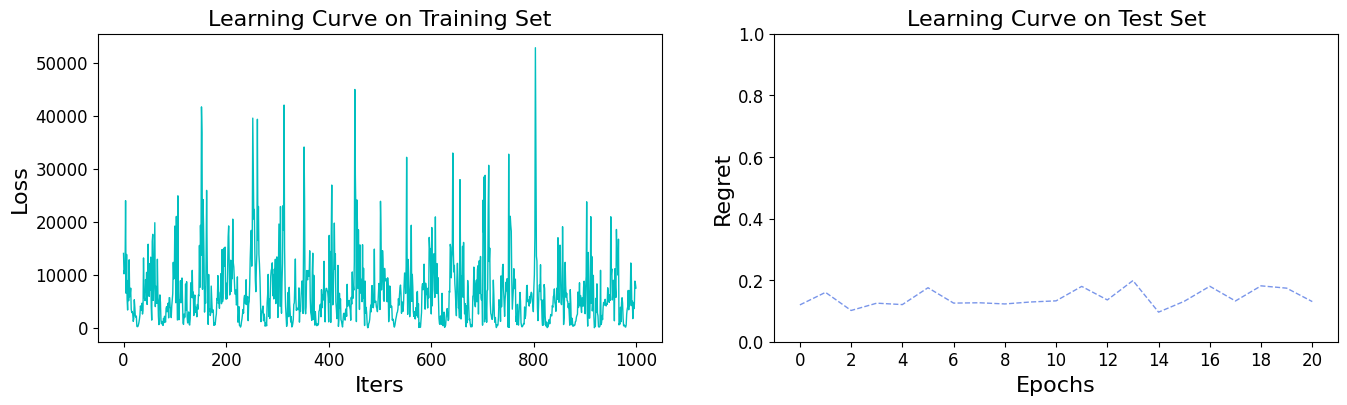

In [ ]:
visLearningCurve(loss_log, loss_log_regret)

In [ ]:
for data in loader_train:
    x, c, w, z = data
    # cuda
    if torch.cuda.is_available():
        x, c, w, z = x.cuda(), c.cuda(), w.cuda(), z.cuda()
    # forward pass
    cp = reg(x)
    print(cp)
    break


tensor([[  73.5468,  118.9732,   86.2337,  105.8148,   74.5600,   52.5004,
           93.5348,   78.9880,   63.9228,   93.4311,   99.0079,   94.7690,
           94.3152,   77.7097,   91.4928,   83.5319,   74.1805,   69.2801,
           90.9795,   98.3776,  109.4495,   83.7620,   94.8622,  109.4124,
          -54.5121,  -59.7605,  -45.2815,  -84.2073,  -91.6669, -101.3159,
          -77.4850,  -91.5839, -110.1920,  -56.1562,  -64.7541,  -43.2940,
           54.7954,   59.4353,   42.0992,  -98.5492,  -85.9656, -108.6260,
          -82.6831,  -61.6253,  -65.5810,  -89.1724,  -71.7380,  -74.9801,
          -22.7588,   13.7576,   18.1717,   -2.4638,  -36.0462,  -12.6659,
          -29.9727,  -13.5523,  -39.8004,   55.1200,   49.9153,   53.6728,
           64.8909,   45.9516,   31.1580,  -38.4509,  -89.8980, -126.9334,
          -50.7990,  -16.3419,   31.8747,  -31.3599,   19.6280,  -24.6146,
          -57.8432,   20.8636,    2.1942,  -43.8282,  -50.7846,  -85.2045,
          -80.7060,  -66.

In [15]:

# optimization model
class hydrogenPlanning(optGrbModel):
    def __init__(self, realized, *args, **kwargs):        
        #Fixed parameters
        self.max_elec = 10
        self.max_wind = 10
        self.nominal_wind = 10
        self.min_production = 50
        self.periods = np.arange(len(realized))
        self.E_real = realized
        super().__init__()

    def _getModel(self):

        initial_plan = Model("Gurobi.Optimizer")

        # Definition of variables
        x = initial_plan.addMVar((4*len(self.periods)), name="x")
        """
        hydrogen_plan = initial_plan.addVars(self.periods, name="p_H", lb=0)
        forward_bid = initial_plan.addVars(self.periods, name="p_F")
        p_UP = initial_plan.addVars(self.periods, name="p_UP", lb=0)
        p_DW = initial_plan.addVars(self.periods, name="p_DW", lb=0)
        """

        # Objective: Maximize profit
        initial_plan.modelSense = GRB.MAXIMIZE
        #initial_plan.setObjective(
        #    quicksum(
        #        lambda_F[t] * p_F[t] +
        #        lambda_H * hydrogen[t] +
        #        lambda_DW[t] * E_DW[t] -
        #        lambda_UP[t] * E_UP[t]
        #        for t in periods
        #    ), GRB.MAXIMIZE
        #)

        # Constraints
        # Max capacity
        initial_plan.addConstr(self.min_production <= gp.quicksum(x[t] for t in self.periods), name="min_hydrogen_production")
        for t in np.arange(0,len(self.periods)):
            initial_plan.addConstr(x[t] >= 0, name=f"elec_capacity_lb_{t}")
            initial_plan.addConstr(x[t] <= self.max_elec, name=f"elec_capacity_ub_{t}")
        for t in np.arange(len(self.periods),2*len(self.periods)):
            initial_plan.addConstr(x[t] >= -self.max_elec, name=f"wind_capacity_lb_{t}")
            initial_plan.addConstr(x[t] <= self.max_wind, name=f"wind_capacity_ub_{t}")
        for t in np.arange(2*len(self.periods),3*len(self.periods)):
            initial_plan.addConstr(x[t] >= 0, name=f"up_regulation_lb_{t}")
            initial_plan.addConstr(x[t] <= 10*self.max_wind, name=f"up_regulation_ub_{t}")
        for t in np.arange(3*len(self.periods),4*len(self.periods)):
            initial_plan.addConstr(x[t] >= 0, name=f"dw_regulation_lb_{t}")
            initial_plan.addConstr(x[t] <= 10*self.max_wind, name=f"dw_regulation_ub_{t}")
        for t in np.arange(0,len(self.periods)):
            initial_plan.addConstr(self.E_real[t] - x[t] - x[t+24] == -x[t+48] + x[t+72], name=f"balancing_{t}")
            #initial_plan.addConstr(-x[0,t] + self.min_production/len(self.periods) - x[4,t] <= 0, name=f"slack_{t}")
        initial_plan.addConstr(gp.quicksum(x[t] for t in np.arange(0,len(self.periods))) == self.min_production, name="min_hydrogen_production")

        # Finalizing model setup
        #initial_plan.update()
        #print(type(hydrogen_plan))
        #x = dict(hydrogen_plan).update(dict(forward_bid)).update(dict(p_UP)).update(dict(p_DW)).update(dict(p_slack))
        #print(hydrogen_plan, forward_bid, p_UP, p_DW, p_slack)
        #x = initial_plan.getVars()
        #x = dict(zip([v.varName for v in x], x))
        
        return initial_plan, x